# Example application of ORD datasets for downstream machine learning modeling

In [1]:
# Import modules
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wget
from sklearn.model_selection import KFold

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import model_selection, metrics
from glob import glob

2024-09-22 20:25:12.921309: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 20:25:12.989302: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-22 20:25:13.296498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 20:25:13.296533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 20:25:13.363455: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# 读取所有数据的列标题
df = pd.read_csv('origin.csv')
list(df.columns)

['inputs["Boronate in Solvent"].components[0].identifiers[0].value',
 'inputs["Boronate in Solvent"].components[1].identifiers[0].value',
 'inputs["Ligand in Solvent"].components[0].identifiers[0].value',
 'inputs["Ligand in Solvent"].components[0].amount.moles.value',
 'inputs["Ligand in Solvent"].components[0].amount.moles.units',
 'inputs["Ligand in Solvent"].components[0].reaction_role',
 'inputs["Ligand in Solvent"].components[1].identifiers[0].type',
 'inputs["Ligand in Solvent"].components[1].identifiers[0].value',
 'inputs["Ligand in Solvent"].components[1].amount.volume.value',
 'inputs["Ligand in Solvent"].components[1].amount.volume.units',
 'inputs["Ligand in Solvent"].components[1].amount.volume_includes_solutes',
 'inputs["Ligand in Solvent"].components[1].reaction_role',
 'inputs["Aryl Halide"].components[0].identifiers[0].value',
 'inputs["Solvent_1"].components[0].identifiers[0].value',
 'inputs["Base in Solvent"].components[0].identifiers[0].value',
 'inputs["Base in 

In [3]:
# 创建一个新的只用于模型训练的数据集
model_cols = [
    'inputs["Aryl Halide"].components[0].identifiers[0].value',
    'inputs["Boronate in Solvent"].components[0].identifiers[0].value',
    'inputs["Ligand in Solvent"].components[0].identifiers[0].value',
    'inputs["Base in Solvent"].components[0].identifiers[0].value',
    'inputs["Solvent_1"].components[0].identifiers[0].value',
    "outcomes[0].products[0].measurements[0].percentage.value",
]
df = df[model_cols]

df.to_csv('output1.csv', index=False) # 保存为csv文件

In [4]:
# 检查是否存在空数据
print(f"number of NaN values: {df.isnull().sum().sum()}")

# 输出列的分布情况
df.info()

number of NaN values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5760 entries, 0 to 5759
Data columns (total 6 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   inputs["Aryl Halide"].components[0].identifiers[0].value          5760 non-null   object 
 1   inputs["Boronate in Solvent"].components[0].identifiers[0].value  5760 non-null   object 
 2   inputs["Ligand in Solvent"].components[0].identifiers[0].value    5760 non-null   object 
 3   inputs["Base in Solvent"].components[0].identifiers[0].value      5760 non-null   object 
 4   inputs["Solvent_1"].components[0].identifiers[0].value            5760 non-null   object 
 5   outcomes[0].products[0].measurements[0].percentage.value          5760 non-null   float64
dtypes: float64(1), object(5)
memory usage: 270.1+ KB


In [5]:
# 对产率一列的数据统计
df['outcomes[0].products[0].measurements[0].percentage.value'].describe()

count    5760.000000
mean       40.109446
std        28.081087
min         0.000000
25%        16.197501
50%        33.580000
75%        62.870001
max       100.000000
Name: outcomes[0].products[0].measurements[0].percentage.value, dtype: float64

In [6]:
# 将反应输入转化为ONE-HOT编码

input_cols = model_cols[:-1]

# 输入的前缀部分
prefix = ["electrophile", "nucleophile", "ligand", "base", "solvent"]

# 创建ONE-HOT数据集
ohe_df = pd.get_dummies(df[input_cols], prefix=prefix)

# 添加产率列
ohe_df["yield"] = df[model_cols[-1]] / 100

# 输出为CSV文件
ohe_df.to_csv('output2.csv', index=False)

# 数据集可视化
ohe_df



,electrophile_BrC1=C(C)C=CC2=C1C=NN2C3CCCCO3,electrophile_BrC1=CC=C2N=CC=CC2=C1,electrophile_ClC1=CC=C2N=CC=CC2=C1,electrophile_IC1=CC=C2N=CC=CC2=C1,electrophile_O=S(OC1=CC=C2N=CC=CC2=C1)(C(F)(F)F)=O,nucleophile_B(c1c(ccc2c1cnn2C3CCCCO3)C)(O)O,nucleophile_CC1(OB(C2=CC=C3N=CC=CC3=C2)OC1(C)C)C,nucleophile_Cc1ccc2n(C3CCCCO3)ncc2c1B4OC(C)(C)C(C)(C)O4,nucleophile_F[B-](F)(C1=C(C)C=CC2=C1C=NN2C3CCCCO3)F.[K+],nucleophile_OB(C1=CC=C2N=CC=CC2=C1)O.[H]Cl,...,base_[F-].[Cs+],base_[Li+].CC(C)(C)[O-],base_[O-]P(=O)([O-])[O-].[K+].[K+].[K+],base_[OH-].[K+],base_[OH-].[Na+],solvent_C1CCOC1,solvent_CC#N,solvent_CN(C)C=O,solvent_CO,yield
0,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,0.0476
1,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,0.0412
2,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,0.0258
3,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,0.0444
4,False,False,True,False,False,True,False,False,False,False,...,False,False,False,False,True,False,True,False,False,0.0195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,True,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,0.4721
5756,True,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,0.0000
5757,True,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,0.3144
5758,True,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,True,False,0.0000


## 知识图谱的构建

In [11]:
from neo4j import GraphDatabase
import pandas as pd

# Neo4j 连接信息
NEO4J_URI = "neo4j+s://9228cc3b.databases.neo4j.io"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "9TqkXiPumrBELi663FM8fdcqIg3HjPkmUEbNhxYqnHE"

# 读取 Suzuki 反应数据
df = pd.read_csv("visualization/Suzuki_1.csv")

# 连接 Neo4j 数据库
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

def create_reaction_network(tx, data):
    """
    创建化学反应网络知识图谱.

    Args:
        tx: Neo4j 事务对象.
        data: pandas DataFrame, 包含 Suzuki 反应数据.
    """
    for i, row in data.iterrows():
        # 创建反应节点
        reaction_node = f"""
            MERGE (r:Reaction {{
                aryl_halide: '{row['Aryl Halide']}',
                boronate: '{row['Boronate']}',
                ligand: '{row['Ligand']}',
                base: '{row['Base']}',
                solvent: '{row['Solvent']}',
                yield: {row['Yield']}
            }})
        """
        tx.run(reaction_node)

        # 创建分子节点和关系
        for role, molecule in [("aryl_halide", row['Aryl Halide']), 
                               ("boronate", row['Boronate']),
                               ("ligand", row['Ligand']), 
                               ("base", row['Base']),
                               ("solvent", row['Solvent'])]:
            if molecule != "None":
                molecule_node = f"""
                    MERGE (m:Molecule {{ name: '{molecule}' }})
                """
                tx.run(molecule_node)

                relation = f"""
                    MATCH (r:Reaction {{ {role}: '{molecule}' }})
                    MATCH (m:Molecule {{ name: '{molecule}' }})
                    MERGE (r)-[:{role.upper()}]->(m)
                """
                tx.run(relation)

# 在事务中创建知识图谱
with driver.session() as session:
    session.write_transaction(create_reaction_network, df)

# 关闭数据库连接
driver.close()

/tmp/ipykernel_167267/256429704.py:58: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_reaction_network, df)


KeyboardInterrupt: 

## 训练数据集的创建

In [131]:
# 创建输入和输出矩阵
X = ohe_df.drop(columns=["yield"]).values
y = ohe_df["yield"].values

# 输出形状用于验证
print(X.shape, y.shape)

(5760, 35) (5760,)


In [132]:
# 将数据集划分为训练集、验证集和测试集
_X_train, X_test, _y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    _X_train, _y_train, test_size=(0.1 / 0.7), shuffle=False
)

# 打印矩阵规格用于验证
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(ohe_df) == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

(3455, 35) (3455,)
(577, 35) (577,)
(1728, 35) (1728,)
True


In [133]:
# 创建用于神经网络构建的数据集
batch_size = 50
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# 检查每一个batch中的数据量
print(train_dataset.cardinality().numpy())
print(valid_dataset.cardinality().numpy())
print(test_dataset.cardinality().numpy())

70
12
35


## 设置神经网络模型

In [41]:
# 超参数寻优
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
def create_model(neurons_1=50, neurons_2=7, dropout_rate=0.2, learning_rate=0.005,activation = 'sigmoid'):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=X_train.shape[1]),
            tf.keras.layers.Dense(neurons_1, activation=activation),
            tf.keras.layers.Dense(neurons_2, activation=activation),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    return model

# Define hyperparameter search space
param_dist = {
    "neurons_1": [ 50, 100],
    "neurons_2": [7, 14, 28],
    "dropout_rate": [0.1, 0.2, 0.3],
    "learning_rate": [0.001, 0.005, 0.01],
    'activation': ['relu', 'sigmoid'],
    "epochs": [100, 200, 300], 
    "batch_size": [50, 100]  
}

model = KerasClassifier(
    build_fn=create_model(),  
    verbose=0
)
 
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  
    scoring="neg_root_mean_squared_error", 
    cv=3,  
    n_jobs=-1,  
    verbose=2,
)

random_search.fit(X_train, y_train)


ImportError: cannot import name '_deprecate_Xt_in_inverse_transform' from 'sklearn.utils.deprecation' (/root/miniconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py)

In [151]:
# Set model parameters
epochs = 300

# Construct model
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=X_train.shape[1]),
        tf.keras.layers.Dense(100, activation="ReLU"),
        tf.keras.layers.Dense(14, activation="ReLU"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1),
    ]
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

# Setup callback to load weights from best epoch later on
# Saving model weights from epoch with lowest validation loss
checkpoint_filepath = os.path.join(os.getcwd(), "saved_model")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor="val_loss", mode="min", save_best_only=True
)

# Train model
history = model.fit(train_dataset, epochs=epochs, callbacks=[model_checkpoint_callback], validation_data=valid_dataset)

Epoch 1/300
70/70 [==============================] - 1s 8ms/step - loss: 0.0665 - root_mean_squared_error: 0.2578 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1784
Epoch 2/300
70/70 [==============================] - 0s 7ms/step - loss: 0.0331 - root_mean_squared_error: 0.1821 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1577
Epoch 3/300
70/70 [==============================] - 0s 6ms/step - loss: 0.0307 - root_mean_squared_error: 0.1751 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1483
Epoch 4/300
70/70 [==============================] - 0s 6ms/step - loss: 0.0273 - root_mean_squared_error: 0.1652 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1466
Epoch 5/300
48/70 [===================>..........] - ETA: 0s - loss: 0.0233 - root_mean_squared_error: 0.1527

WARNING 2024-07-07 05:32:10,178 checkpoint.py:225: Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
WARNING 2024-07-07 05:32:10,179 checkpoint.py:234: Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total
WARNING 2024-07-07 05:32:10,179 checkpoint.py:234: Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count
WARNING 2024-07-07 05:32:10,180 checkpoint.py:234: Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total
WARNING 2024-07-07 05:32:10,180 checkpoint.py:234: Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count
W

70/70 [==============================] - 1s 13ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1407
Epoch 6/300
70/70 [==============================] - 0s 6ms/step - loss: 0.0221 - root_mean_squared_error: 0.1486 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1363
Epoch 7/300
70/70 [==============================] - 0s 6ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1332
Epoch 8/300
70/70 [==============================] - 0s 1ms/step - loss: 0.0197 - root_mean_squared_error: 0.1404 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 9/300
70/70 [==============================] - 0s 7ms/step - loss: 0.0184 - root_mean_squared_error: 0.1355 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 10/300
70/70 [==============================] - 0s 6ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0172 - val_root_mean_square

In [152]:
# Show best epoch
best_epoch = np.argmin(np.array(history.history["val_loss"]))
best_val_loss = np.min(np.array(history.history["val_loss"]))
print(f"Best Epoch: {best_epoch+1} with Validation Loss: {best_val_loss}")

Best Epoch: 26 with Validation Loss: 0.013019909150898457


35/35 [==============================] - 0s 1ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096
Test RMSE: {'loss': 0.012020564638078213, 'root_mean_squared_error': 0.10963833332061768}
Test R2: 0.8456231534979417


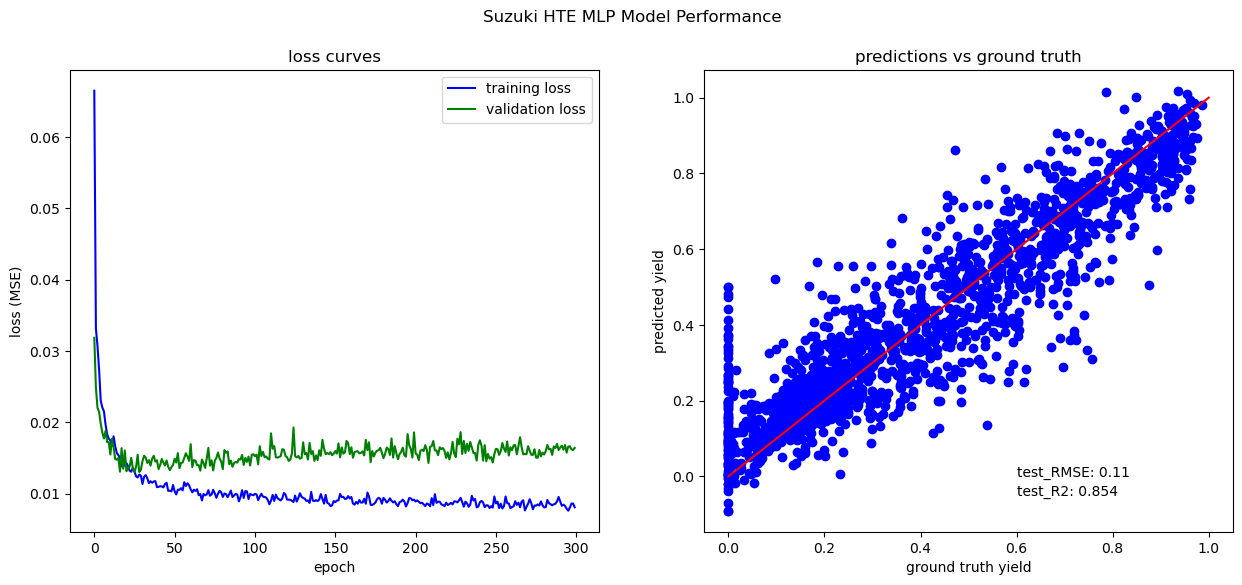

In [154]:
# Load model weights from best epoch
model.load_weights(os.path.join(checkpoint_filepath, "variables/variables"))

# 产生测试集的RMSE和R2
preds = model.predict(test_dataset)
evals = model.evaluate(x=test_dataset, return_dict=True) 
r2 = metrics.r2_score(y_test, preds)
rmse = evals["root_mean_squared_error"]
print(f"Test RMSE: {evals}")
print(f"Test R2: {r2}")

# 以下为利用matplotlib来进行绘图的代码，绘制模型在测试集中的性能表现
# Plot model performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Suzuki HTE MLP Model Performance")

# Plot loss through training
ax1.plot(history.history["loss"], "b", label="training loss")
ax1.plot(history.history["val_loss"], "g", label="validation loss")
ax1.legend()
ax1.set_ylabel("loss (MSE)")
ax1.set_xlabel("epoch")
ax1.set_title("loss curves")

# Plot predictions vs ground truth
ax2.plot(y_test, preds, "bo")
ax2.plot([0, 1], "r")
ax2.set_ylabel("predicted yield")
ax2.set_xlabel("ground truth yield")
ax2.set_title("predictions vs ground truth")
ax2.text(0.6, 0, f"test_RMSE: {round(0.11, 3)}")
ax2.text(0.6, -0.05, f"test_R2: {round(0.854, 3)}")

# View performance plots
plt.savefig('performance.png')
plt.show()


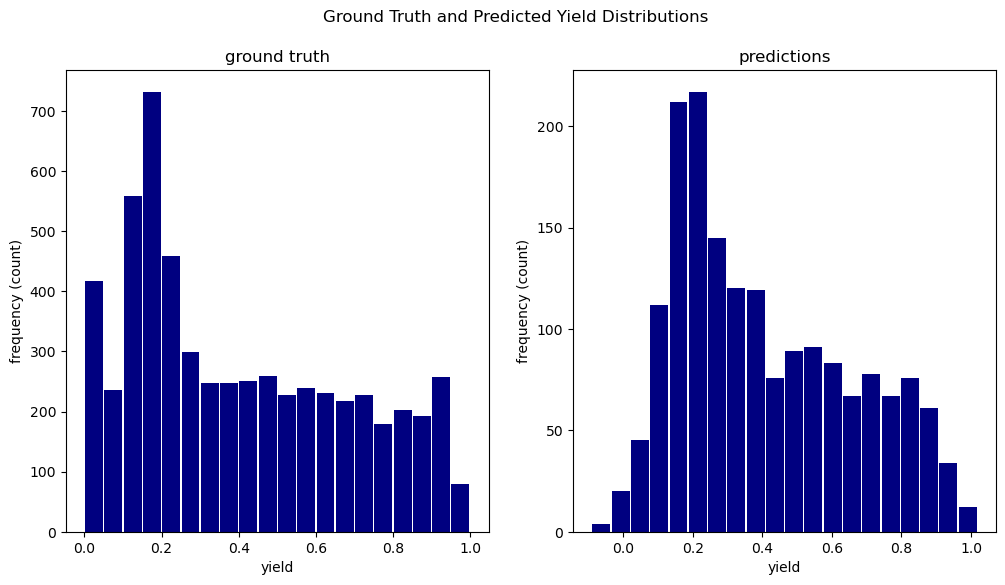

In [155]:
# 以下为实际值和预测值的分布情况图绘制
# Show ground truth and predicted yield distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Ground Truth and Predicted Yield Distributions")

# Plot ground truth histogram
ax1.hist(ohe_df["yield"], bins=20, rwidth=0.93, color="navy")
ax1.set_title("ground truth")
ax1.set_xlabel("yield")
ax1.set_ylabel("frequency (count)")

# Plot predicted histogram
ax2.hist(preds, bins=20, rwidth=0.93, color="navy")
ax2.set_title("predictions")
ax2.set_xlabel("yield")
ax2.set_ylabel("frequency (count)")

# View distributions
plt.savefig('distributions.png')
plt.show()


In [120]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import tensorflow as tf

# 创建输入和输出矩阵
X = ohe_df.drop(columns=["yield"]).values
y = ohe_df["yield"].values

# 首先，从数据集中分离出独立的测试集
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义五折交叉验证，应用于剩余数据集
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 初始化用于存储每一折的评估结果的列表
fold_performance = []

# 对每一折进行迭代
for fold, (train_index, val_index) in enumerate(kf.split(X_remaining, y_remaining)):
    print(f"Training on fold {fold+1}/5...")
    X_train_fold, X_val_fold = X_remaining[train_index], X_remaining[val_index]
    y_train_fold, y_val_fold = y_remaining[train_index], y_remaining[val_index]
    
    # 创建TensorFlow数据集
    train_dataset_fold = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(batch_size)
    val_dataset_fold = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold)).batch(batch_size)
    
    # 构建和编译模型（这里使用与原始代码相同的模型架构和编译设置）
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=X_train_fold.shape[1]),
        tf.keras.layers.Dense(50, activation="ReLU"),
        tf.keras.layers.Dense(7, activation="ReLU"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    # 训练模型
    history = model.fit(train_dataset_fold, epochs=epochs, validation_data=val_dataset_fold)
    
    # 保存最佳epoch的性能
    best_epoch = np.argmin(np.array(history.history["val_loss"]))
    best_val_loss = np.min(np.array(history.history["val_loss"]))
    print(f"Best Epoch: {best_epoch+1} with Validation Loss: {best_val_loss}")
    fold_performance.append(best_val_loss)

# 计算并打印交叉验证的平均性能
print(f"Average Validation Loss across folds: {np.mean(fold_performance)}")

# 使用独立的测试集评估模型性能

Training on fold 1/5...
Epoch 1/300
74/74 [==============================] - 1s 2ms/step - loss: 0.0566 - root_mean_squared_error: 0.2378 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1698
Epoch 2/300
74/74 [==============================] - 0s 1ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1559
Epoch 3/300
74/74 [==============================] - 0s 1ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1474
Epoch 4/300
74/74 [==============================] - 0s 1ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 5/300
74/74 [==============================] - 0s 1ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338
Epoch 6/300
74/74 [==============================] - 0s 1ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545 - val_l

In [138]:
import random
class ChemicalSpace():
    ''' Abstract class of chemical space for simulating navigation of 
        reaction space using machine learning'''
    def __init__(self, df, seed=42):
        # seed for reproduciibity
        random.seed(seed)
        self.df = df
        self.index = list(df.index)
        self.explored_space_index = []
        self.space_len = len(self.index)
        # randomize the indexes
        random.shuffle(self.index)
        
        
        
    def random_guess(self, percent):
        '''Returns the dataframe with random rxns from chemical space'''
        
        num_of_rxns = int(self.space_len * percent)
        
        random_rxns_idxs = []
        
        for idx  in self.index:
            if idx not in self.explored_space_index:
                self.explored_space_index.append(idx)
                random_rxns_idxs.append(idx)
                if len(random_rxns_idxs) == num_of_rxns:
                    break
        random_df = self.df.loc[random_rxns_idxs]
        return random_df
    
    
    
    
    def get_unused(self):
        ''' Return a dataframe of all reactions which has not been explored so far'''
        
        unused_rxn_idxs = []
        
        for idx in self.index:
            if idx not in self.explored_space_index:
                unused_rxn_idxs.append(idx)
                
        unused_rxns = self.df.loc[unused_rxn_idxs]
        return unused_rxns
        
    def get_explored(self):
        ''' Return a dataframe with indexes of reactions which have been chosen'''
        
        return self.df.loc[self.explored_space_index]
    
    def update_explored_rxns(self, rxn_idxs):
        ''' Add rxn_idxs to the list of explored reactions'''
        self.explored_space_index += rxn_idxs
        
    def is_empty(self):
        ''' Return True if the whole chemical space has been explored'''
        if len(self.explored_space_index) == self.space_len:
            return True
        else:
            return False
        
    def percent_explored(self):
        ''' Return the percent of exploration of chemical space'''
        return len(self.explored_space_index)/self.space_len

